In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, activations
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-22 16:28:56.302577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 16:28:56.700475: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 16:28:56.714936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 16:28:56.714966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
train_df = pd.read_csv('train_2Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_2Dx.csv',nrows=500000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    #x = BatchNormalization()(x)
    x = Dense(2, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0025),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168)]             0         
                                                                 
 dense1 (Dense)              (None, 64)                10816     
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 2)                 130       
                                                                 
Total params: 10,946
Trainable params: 10,946
Non-trainable params: 0
_________________________________________________________________


2022-11-22 16:29:55.114826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 16:29:55.114925: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 16:29:55.114978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2022-11-22 16:29:55.115550: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=1000, 
                    batch_size=2048,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000
391/391 [==============================] - 5s 9ms/step - loss: 6.4892 - val_loss: 5.1868
Epoch 2/1000
391/391 [==============================] - 3s 8ms/step - loss: 5.1631 - val_loss: 5.1173
Epoch 3/1000
391/391 [==============================] - 3s 8ms/step - loss: 5.0161 - val_loss: 4.8804
Epoch 4/1000
391/391 [==============================] - 3s 8ms/step - loss: 4.7193 - val_loss: 4.5866
Epoch 5/1000
391/391 [==============================] - 3s 8ms/step - loss: 4.5228 - val_loss: 4.4569
Epoch 6/1000
391/391 [==============================] - 3s 8ms/step - loss: 4.3866 - val_loss: 4.3052
Epoch 7/1000
391/391 [==============================] - 3s 8ms/step - loss: 4.2450 - val_loss: 4.1910
Epoch 8/1000
391/391 [==============================] - 3s 8ms/step - loss: 4.1471 - val_loss: 4.0949
Epoch 9/1000
391/391 [==============================] - 3s 8ms/step - loss: 4.0453 - val_loss: 3.9938
Epoch 10/1000
391/391 [==============================] - 3s 8ms/step - loss: 3.956

/tmp/ipykernel_148780/4052347745.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


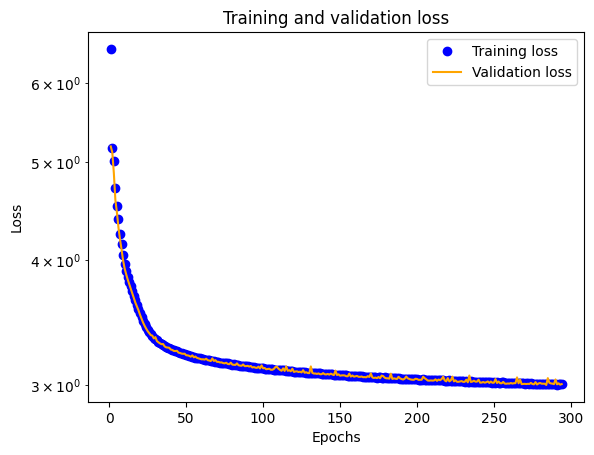

In [9]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()

In [10]:
model.save('models_2Dx/gauss.keras')

In [11]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = 0.1 + tf.math.softplus(df['sigma'])
df['xtrue'] = y_test
df.to_csv("test_2DxGauss.csv",header=False,index=False)

15625/15625 [==============================] - 24s 2ms/step


In [12]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

-0.7579188824918633 7.361528485161981


In [13]:
uncertainty= 0.1 + tf.math.softplus(p_test[:,1])
print(np.mean(uncertainty),np.std(uncertainty))

4.0649934 3.7010636


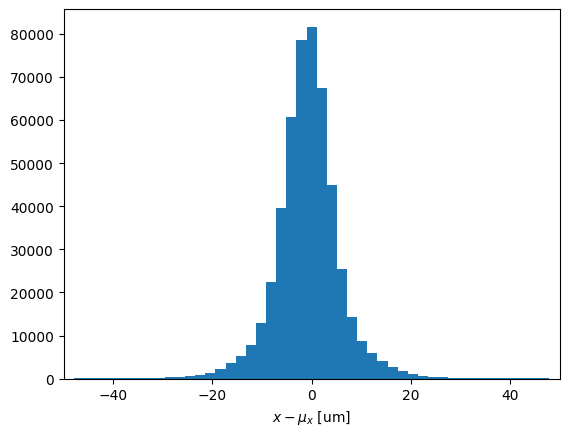

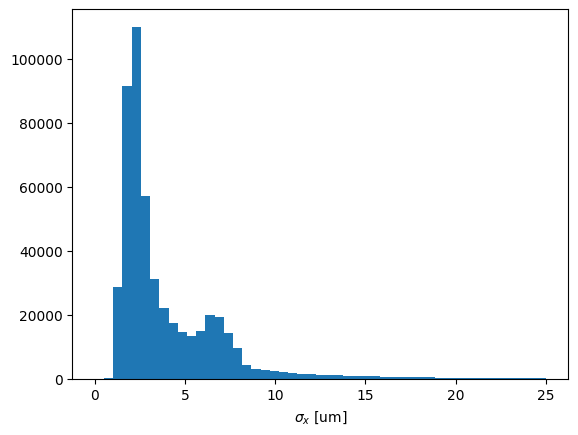

In [14]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.xlim(-50,50)
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [15]:
pulls = residuals/p_test[:,1]
print(np.mean(pulls),np.std(pulls))

-0.35538935958338647 2.11117793905907


Text(0.5, 0, 'pull')

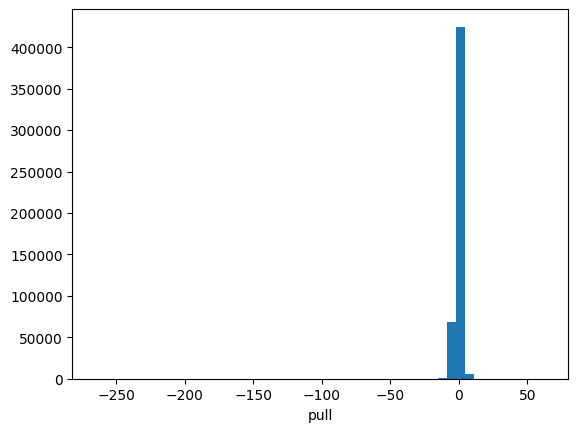

In [16]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [17]:
df_2d = pd.DataFrame(p_test,columns=['mu','sigma'])
df_2d['xtrue'] = y_test
df_2d.head()

,mu,sigma,xtrue
0,-39.828197,4.012679,-46.684825
1,48.349579,6.748332,63.321594
2,-52.612896,1.429968,-54.243993
3,28.153170,5.280723,26.554883
4,57.568977,1.880128,58.023551


In [18]:
df_1d = pd.read_csv('test_1DxGauss.csv',header=None,names=['mu','sigma','xtrue'])
df_1d.head()

,mu,sigma,xtrue
0,29.969585,5.203071,35.970951
1,-0.287672,4.929564,0.770363
2,-30.719051,6.458121,-37.471662
3,-19.176640,5.216318,-10.147963
4,-70.969380,4.316263,-73.204875


Text(0.5, 0, '$x-\\mu_x$ [um]')

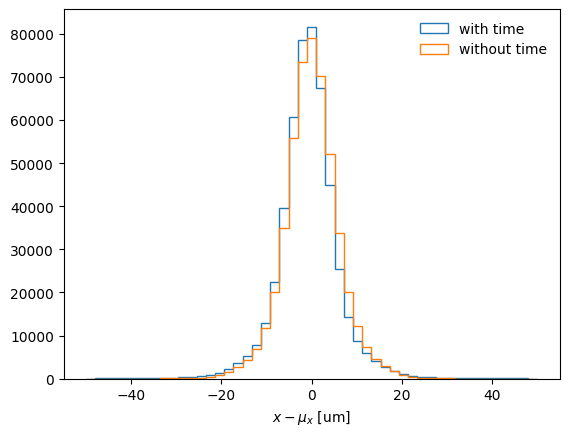

In [19]:
plt.hist(df_2d['xtrue'] - df_2d['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'with time');
plt.hist(df_1d['xtrue'] - df_1d['mu'],histtype='step',bins=np.linspace(-50,50,50),label=r'without time');
plt.legend(frameon=False)
plt.xlabel(r'$x-\mu_x$ [um]')

Text(0.5, 0, '$\\sigma_x$ [um]')

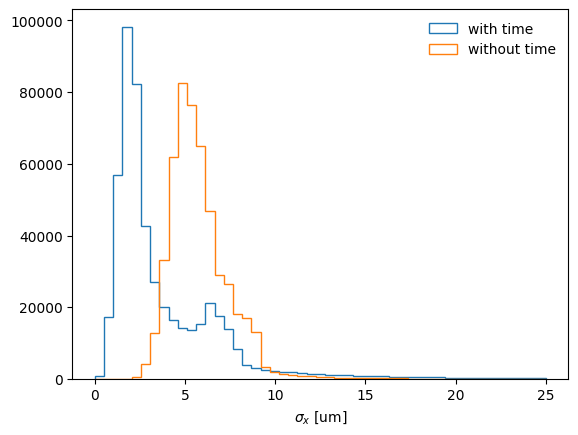

In [20]:
plt.hist(df_2d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'with time');
plt.hist(df_1d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'without time');
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')

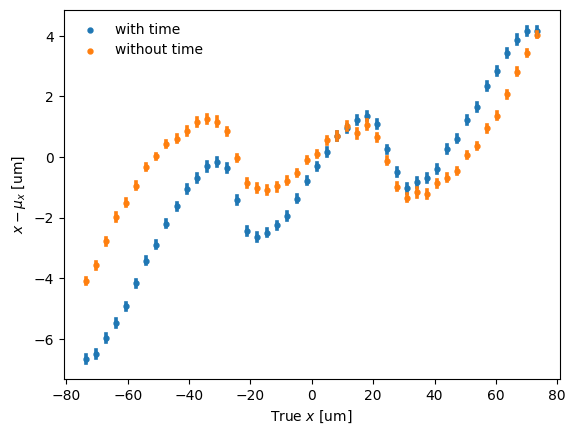

In [29]:
x = sns.regplot(x=df_2d['xtrue'], y=df_2d['xtrue']-df_2d['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='with time')
x = sns.regplot(x=df_1d['xtrue'], y=df_1d['xtrue']-df_1d['mu'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='without time')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend(frameon=False)

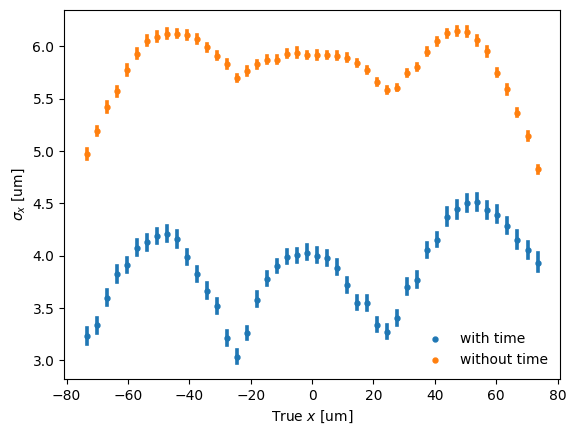

In [30]:
x = sns.regplot(x=df_2d['xtrue'], y=df_2d['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='with time')
x = sns.regplot(x=df_1d['xtrue'], y=df_1d['sigma'], x_bins=np.linspace(-80,80,50), fit_reg=None, marker='.',label='without time')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')
plt.legend(frameon=False)

Text(0.5, 0, 'true x [um]')

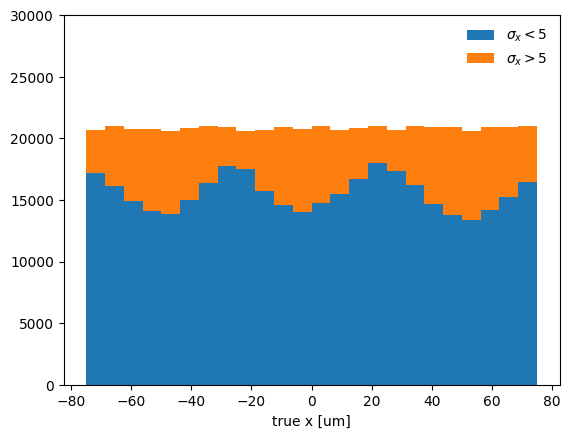

In [23]:
plt.hist([df_2d[df_2d['sigma']<5]['xtrue'],df_2d[df_2d['sigma']>5]['xtrue']],bins=np.linspace(-75,75,25),stacked=True,label=['$\sigma_x<5$','$\sigma_x>5$']);
plt.ylim(0,30000)
plt.legend(frameon=False)
plt.xlabel('true x [um]')

Text(0, 0.5, '$\\sigma_x$ [um]')

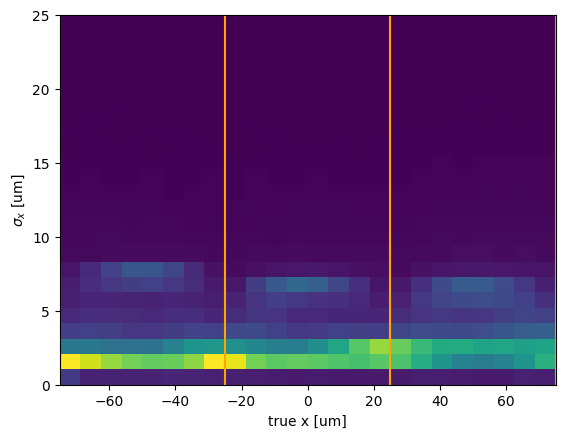

In [24]:
plt.hist2d(df_2d['xtrue'],df_2d['sigma'],bins=[np.linspace(-75,75,25),np.linspace(0,25,25)]);
plt.plot([-75,-75],[0,25],color='orange')
plt.plot([-25,-25],[0,25],color='orange')
plt.plot([25,25],[0,25],color='orange')
plt.plot([75,75],[0,25],color='orange')
plt.xlabel('true x [um]')
plt.ylabel(r'$\sigma_x$ [um]')

In [25]:
model.layers

In [26]:
max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())

/tmp/ipykernel_148780/2940326780.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())


7.640102

In [27]:
max(np.array(model.layers[3].get_weights()).flatten()[0].flatten())

/tmp/ipykernel_148780/3000422521.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  max(np.array(model.layers[3].get_weights()).flatten()[0].flatten())


24.989897